# Analyzing networks of characters in _Love Actually_ in Python

Source material in R: http://varianceexplained.org/r/love-actually-network/

Making sure my Anaconda installation is equivalent to Python [Root] here...

In [1]:
!which python

/cygdrive/c/users/narho_000/anaconda3/python


**David's original stated goal**: "Visualize the connections quantitatively, based on how often characters share scenes."

Tasks accomplished in R:
1. Organize the raw data into a table
2. Create a binary speaker-by-scene matrix
5. Hierarchical clustering
6. Timeline visualization
7. Coocurrence heatmap
8. Network graph visualization
9. Output data frame in a way R can consume for Shiny app usage

Tasks 1-2 are data munging/parsing/tidying. 3-6 are analysis and visualization. Task 7 is R-friendly output.

## Organize the raw data into a table

**Section subgoals**: read in script lines; map characters to actors; transform script into a data frame with scene#, line#, character speaking, line of dialogue, and actor

David uses the R package `dplyr` extensively (along with a little `stringr` and `tidyr`) and in a very dense way to perform reach this goal. We'll need to unpack this in order to understand and then translate it to Python.

In [2]:
import os

BASE_DIR = os.getcwd()
RAWDATA_DIR = BASE_DIR + '/rawdata'

raw_script = RAWDATA_DIR + '/love_actually.txt'
cast_csv = RAWDATA_DIR + '/love_actually_cast.csv'

In [3]:
from pandas import DataFrame
import pandas as pd
import numpy as np

# read in the script
with open(raw_script, 'r', encoding='utf8') as s:
    raw_df = DataFrame({'raw': s.readlines()})
raw_df[:10]

,raw
0,﻿Love Actually Scripts\n
1,\n
2,\n
3,\n
4,[ Scene #1 ]\n
5,(Man): 'Whenever I get gloomy with the state o...
6,I think about the arrival's gate at Heathrow...
7,General opinion started to make out that we ...
8,but I don't see that. Seems to me that love ...
9,Often it's not particularly dignified or new...


In [4]:
len(raw_df)

1437

In [5]:
# used for displaying full data while debugging using the form HTML(data.to_html())
#from IPython.display import HTML

In [6]:
# filter out new/empty lines and lines annotated as songs
lines = DataFrame(raw_df[(raw_df.raw.str.strip() != '') & ~(raw_df.raw.str.contains('\(song\)'))])

In [7]:
len(lines)

1265

In [8]:
lines[:10]

,raw
0,﻿Love Actually Scripts\n
4,[ Scene #1 ]\n
5,(Man): 'Whenever I get gloomy with the state o...
6,I think about the arrival's gate at Heathrow...
7,General opinion started to make out that we ...
8,but I don't see that. Seems to me that love ...
9,Often it's not particularly dignified or new...
10,"Fathers and sons, mothers and daughters, hus..."
11,"When the planes hit the Twin Towers, as far ..."
12,none of the phone calls from people on board...


In [9]:
# mutate: add new columns to annotate scene markers and then calculate scene numbers for each line, based on markers.

lines['is_scene'] = np.where(lines.raw.str.contains("\[ Scene #"), True, False)
# fortunately, numpy has a cumsum method like R
lines['scene'] = np.cumsum(np.where(lines.raw.str.contains("\[ Scene #"), True, False))

In [10]:
lines[:10]

,raw,is_scene,scene
0,﻿Love Actually Scripts\n,False,0
4,[ Scene #1 ]\n,True,1
5,(Man): 'Whenever I get gloomy with the state o...,False,1
6,I think about the arrival's gate at Heathrow...,False,1
7,General opinion started to make out that we ...,False,1
8,but I don't see that. Seems to me that love ...,False,1
9,Often it's not particularly dignified or new...,False,1
10,"Fathers and sons, mothers and daughters, hus...",False,1
11,"When the planes hit the Twin Towers, as far ...",False,1
12,none of the phone calls from people on board...,False,1


In [11]:
# clean up now that we're done with the is_scene column
lines = lines[~lines.is_scene] # filter out scene markers
lines = lines.drop('is_scene', axis=1) # remove is_scene column

In [12]:
lines[:10]

,raw,scene
0,﻿Love Actually Scripts\n,0
5,(Man): 'Whenever I get gloomy with the state o...,1
6,I think about the arrival's gate at Heathrow...,1
7,General opinion started to make out that we ...,1
8,but I don't see that. Seems to me that love ...,1
9,Often it's not particularly dignified or new...,1
10,"Fathers and sons, mothers and daughters, hus...",1
11,"When the planes hit the Twin Towers, as far ...",1
12,none of the phone calls from people on board...,1
13,they were all messages of love. \n,1


In [13]:
# take raw and partition by ':'
# if partition exists, left side represents the speaker, right side the dialogue of the speaker
# if partition does not exist, entire line is dialogue
raw_partitioned = lines.raw.str.rpartition(':')

In [14]:
lines['speaker'] = raw_partitioned[0]
lines['dialogue'] = raw_partitioned[2]

In [15]:
# add new column with line numbers
lines['line'] = np.cumsum(lines.speaker != '')

In [16]:
lines[:15]

,raw,scene,speaker,dialogue,line
0,﻿Love Actually Scripts\n,0,,﻿Love Actually Scripts\n,0
5,(Man): 'Whenever I get gloomy with the state o...,1,(Man),'Whenever I get gloomy with the state of the ...,1
6,I think about the arrival's gate at Heathrow...,1,,I think about the arrival's gate at Heathrow...,1
7,General opinion started to make out that we ...,1,,General opinion started to make out that we ...,1
8,but I don't see that. Seems to me that love ...,1,,but I don't see that. Seems to me that love ...,1
9,Often it's not particularly dignified or new...,1,,Often it's not particularly dignified or new...,1
10,"Fathers and sons, mothers and daughters, hus...",1,,"Fathers and sons, mothers and daughters, hus...",1
11,"When the planes hit the Twin Towers, as far ...",1,,"When the planes hit the Twin Towers, as far ...",1
12,none of the phone calls from people on board...,1,,none of the phone calls from people on board...,1
13,they were all messages of love. \n,1,,they were all messages of love. \n,1


In [17]:
# collapse dialogue belonging to the same line into one row:
    # group by scene and line (do not index by group labels, else we'll get a weird multi-level index at the end)
    # aggregate the dialogue across these groups (and aggregate speaker, but each line should have one speaker anyway)
lines = lines.groupby(['scene', 'line'], as_index=False).aggregate({'dialogue': lambda x: x.str.cat().strip(), 'speaker': lambda x: x.str.cat()})

In [18]:
lines[:10]

,scene,line,dialogue,speaker
0,0,0,﻿Love Actually Scripts,
1,1,1,'Whenever I get gloomy with the state of the w...,(Man)
2,2,2,♪ I feel it in my fingers ♪ I feel it in my to...,Billy
3,2,3,"I'm afraid you did it again, Bill.",Joe
4,2,4,"It's just I know the old version so well, you ...",Billy
5,2,5,"Well, we all do. That's why we're making the n...",Joe
6,2,6,"Right, OK, let's go. ♪ I feel it in my fingers...",Billy
7,2,7,"Oh, fuck, wank, bugger, shitting, arsehead and...",Billy
8,2,8,"This is shit, isn't it?",Billy
9,2,9,"Yup, solid gold shit, Maestro.",Joe


^Note that David did everything so far in one (extremely) dense line of code with a bunch of piping!

In [19]:
# read in the character -> actor mapping
with open(cast_csv, 'r') as c:
    cast = pd.read_csv(c)

In [20]:
lines = lines.merge(cast)
lines['character'] = lines['speaker'] + ' (' + lines['actor'] + ')'

# clean up the output
lines = lines.sort_values('line').reset_index(drop=True)

In [21]:
lines[:15]

,scene,line,dialogue,speaker,actor,character
0,2,2,♪ I feel it in my fingers ♪ I feel it in my to...,Billy,Bill Nighy,Billy (Bill Nighy)
1,2,3,"I'm afraid you did it again, Bill.",Joe,Gregor Fisher,Joe (Gregor Fisher)
2,2,4,"It's just I know the old version so well, you ...",Billy,Bill Nighy,Billy (Bill Nighy)
3,2,5,"Well, we all do. That's why we're making the n...",Joe,Gregor Fisher,Joe (Gregor Fisher)
4,2,6,"Right, OK, let's go. ♪ I feel it in my fingers...",Billy,Bill Nighy,Billy (Bill Nighy)
5,2,7,"Oh, fuck, wank, bugger, shitting, arsehead and...",Billy,Bill Nighy,Billy (Bill Nighy)
6,2,8,"This is shit, isn't it?",Billy,Bill Nighy,Billy (Bill Nighy)
7,2,9,"Yup, solid gold shit, Maestro.",Joe,Gregor Fisher,Joe (Gregor Fisher)
8,3,10,"God, I'm so late.",Jamie,Colin Firth,Jamie (Colin Firth)
9,3,11,"It's just round the corner, you'll make it.",Kataya,Sienna Guillory,Kataya (Sienna Guillory)


## Create a binary speaker-by-scene matrix

**Section subgoals**: count lines per scene per character

In [22]:
by_speaker_scene = lines.groupby(['scene', 'character'], as_index=False).size().reset_index(name='n')

In [23]:
by_speaker_scene[:10]

,scene,character,n
0,2,Billy (Bill Nighy),5
1,2,Joe (Gregor Fisher),3
2,3,Jamie (Colin Firth),5
3,3,Kataya (Sienna Guillory),5
4,4,Daniel (Liam Neeson),3
5,4,Karen (Emma Thompson),6
6,5,Colin (Kris Marshall),4
7,6,Jack (Martin Freeman),2
8,6,Judy (Joanna Page),1
9,7,Mark (Andrew Lincoln),4


In [24]:
speaker_scene_matrix = pd.pivot_table(by_speaker_scene, index=['character'],
   columns=['scene'], fill_value=0, aggfunc=np.size)

In [25]:
speaker_scene_matrix.shape

(21, 76)

In [26]:
speaker_scene_matrix

n                            ...                 \
scene                        2  3  4  5  6  7  8  9  10 11 ... 69 70 71 72 73   
character                                                  ...                  
Aurelia (LÃºcia Moniz)        0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0   
Billy (Bill Nighy)            1  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0   
Colin (Kris Marshall)         0  0  0  1  0  0  0  0  0  1 ...  0  0  0  0  0   
Daniel (Liam Neeson)          0  0  1  0  0  0  0  0  0  0 ...  0  0  0  0  1   
Harry (Alan Rickman)          0  0  0  0  0  0  0  0  0  0 ...  0  0  0  1  0   
Jack (Martin Freeman)         0  0  0  0  1  0  0  0  0  0 ...  1  0  0  0  0   
Jamie (Colin Firth)           0  1  0  0  0  0  0  0  1  0 ...  0  0  0  0  0   
Joe (Gregor Fisher)           1  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0   
Judy (Joanna Page)            0  0  0  0  1  0  0  0  0  0 ...  1  0  0  0  0   
Juliet (Keira Knightley)      0  0  0  0  0  0  0  1  0  0 ...  0  0  0  0  0   
Karen (Emma Thompson)         0  0  1  0  0  0  0  0  0  0 ...  0  1  0  1  0   
Karl (Rodrigo Santoro)        0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0   
Kataya (Sienna Guillory)      0  1  0  0  0  0  0  0  0  0 ...  0  0  0  0  0   
Mark (Andrew Lincoln)         0  0  0  0  0  1  0  1  0  1 ...  0  0  0  0  0   
Mia (Heike Makatsch)          0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0   
Natalie (Martine McCutcheon)  0  0  0  0  0  0  1  0  0  0 ...  1  1  1  0  0   
PM (Hugh Grant)               0  0  0  0  0  0  1  0  0  0 ...  1  1  1  0  0   
Peter (Chiwetel Ejiofor)      0  0  0  0  0  1  0  1  0  0 ...  0  0  0  0  0   
Sam (Thomas Sangster)         0  0  0  0  0  0  0  0  0  0 ...  1  0  0  0  1   
Sarah (Laura Linney)          0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0   
Tony (Abdul Salis)            0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0   

                                             
scene                        74 75 77 78 79  
character                                    
Aurelia (LÃºcia Moniz)        0  0  0  1  1  
Billy (Bill Nighy)            0  0  0  0  1  
Colin (Kris Marshall)         0  0  0  0  1  
Daniel (Liam Neeson)          0  1  0  0  1  
Harry (Alan Rickman)          0  0  0  0  1  
Jack (Martin Freeman)         0  0  0  0  1  
Jamie (Colin Firth)           1  0  0  1  1  
Joe (Gregor Fisher)           0  0  0  0  1  
Judy (Joanna Page)            0  0  0  0  1  
Juliet (Keira Knightley)      0  0  0  0  0  
Karen (Emma Thompson)         0  0  0  0  1  
Karl (Rodrigo Santoro)        0  0  0  0  0  
Kataya (Sienna Guillory)      0  0  0  0  0  
Mark (Andrew Lincoln)         0  0  0  0  1  
Mia (Heike Makatsch)          0  0  0  0  0  
Natalie (Martine McCutcheon)  0  0  0  0  1  
PM (Hugh Grant)               0  0  0  0  1  
Peter (Chiwetel Ejiofor)      0  0  0  0  0  
Sam (Thomas Sangster)         0  1  1  0  1  
Sarah (Laura Linney)          0  0  0  0  0  
Tony (Abdul Salis)            0  0  0  0  1  

[21 rows x 76 columns]

## Hierarchical clustering

Now that the data is tidy, let's begin our analysis!

First up: hierarchical clustering will provide an ordering that puts similar characters close together.

In [27]:
# Normalizing so that the # of scenes for each character adds up to 1 (http://varianceexplained.org/r/love-actually-network/#fn:hclust)

# in pandas, axis specifies the axis **along which** to compute
# - so we're summing along the columns (i.e. row sum) and then dividing that sum along rows ('index' in pandas)
norm = speaker_scene_matrix.div(speaker_scene_matrix.sum(axis='columns'), axis='index')

Helpful SciPy documentation:
- [pdist and Manhattan/cityblock distance](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist)
- [Hierarchical clustering](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html)
- [Dendrogram plotting](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram)

In [28]:
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy

# cityblock = Manhattan distance
# complete finds similar clusters
h = hierarchy.complete(pdist(norm, metric='cityblock'))

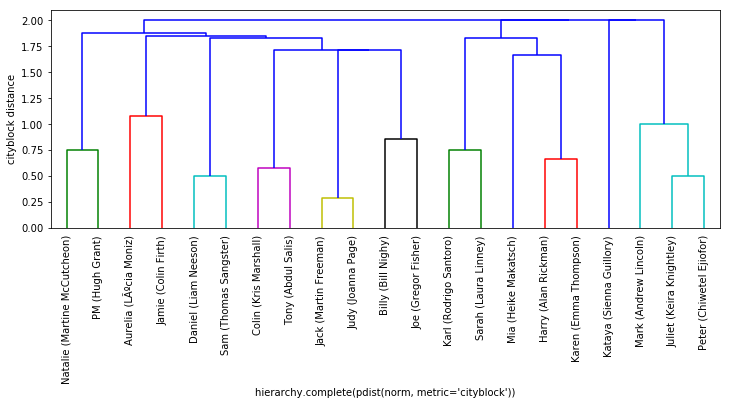

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
dn = hierarchy.dendrogram(h, labels=norm.index.values, leaf_rotation=90)
plt.ylabel('cityblock distance')
plt.xlabel('hierarchy.complete(pdist(norm, metric=\'cityblock\'))')
plt.show()

For an explanation of the y-axis value: https://stats.stackexchange.com/a/95858

I'm just going to go ahead and declare that `matplotlib` is prettier and more readable than R's `graphics/plot` package:

<img src="varianceexplained-dendrogram.png" alt="David's Cluster Dendrogram plot" style="margin: 0;"/>

With `matplotlib`, it's easier to see which pairs are tightest (Jack/Judy, Daniel/Sam, Juliet/Peter) and which characters and clusters are either fairly disconnected from everyone else (Kataya, Mia, Natalie/PM) or fairly connected (Karen/Harry/Mia).

The triads are also pretty interesting (Juliet/Peter/Mark, Harry/Karen/Mia).

**EXTENSION** As suggested by David, try different distance matrix computations and see what changes!

## Visual Timeline

I'm excited for this visualization! It the first one in David's original post that made me go, "huh, cool!"